## Using SHAP for interpretability

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np


from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

import pickle
import shap
shap.initjs()

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_P")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,64.585900,0,27.0,0.377501,128.715226,0.422342,115.630163,15.181458,333.805425,...,286.270009,0.289728,206.373786,44.577974,539.225137,3.320292,22924.739100,3.3445,2251,7338.2
1,0,68.076660,2,20.0,0.657212,51.830551,0.557254,84.225204,8.530596,285.070266,...,282.873623,0.310507,206.276556,39.697933,542.232602,2.864138,18182.687670,2.9605,2924,5438.6
2,1,76.221760,1,28.0,0.520032,86.558742,0.594543,123.662642,13.400504,408.091827,...,244.274039,0.370189,201.216707,46.081559,560.592790,3.415186,28045.350990,3.3145,4042,8434.4
3,0,73.221085,0,30.0,0.396133,60.731686,0.596733,122.546512,15.571183,429.454361,...,226.713342,0.517430,232.983710,30.461877,705.221498,2.937422,1196.160472,3.1505,3485,7476.2
4,0,45.872690,0,30.0,0.404800,108.808540,0.520363,98.065558,13.483247,283.453692,...,202.074647,0.354851,169.528802,50.680275,476.040561,3.017047,47743.254120,3.5420,3964,8021.8


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((508, 22), (219, 22))

In [5]:
imputer_knn = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [6]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [7]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [8]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((508, 22), (219, 22))

In [9]:
sel = ['Age', 'MMSE', 'Hip ASM', 'Hip Variance ', 'Hip Sum Average',
       'Hip Entropy', 'ERC CONTRAST', 'ERC CORRELATION', 'ERC SUM VARIANCE',
       'ERC ENTROPY', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip ASM',
 'Hip Variance ',
 'Hip Sum Average',
 'Hip Entropy',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC SUM VARIANCE',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [11]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((508, 13), (219, 13))

In [12]:
with open("rf_model.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

with open("logit_model.pkl", "rb") as file:
    loaded_model_logit = pickle.load(file)
print(f"{loaded_model_logit} model loaded successfully!")

RandomForestClassifier(class_weight='balanced', max_depth=14, max_features=None,
                       min_samples_leaf=0.03990378621676266,
                       min_samples_split=0.08615932264647401, n_estimators=159,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9459668339682313, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.0063681764012773,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13883729751221288,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=N

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_t)
X_test_s = scaler.transform(X_test_t)

: 

In [ ]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

In [ ]:
# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

In [ ]:
# Compute SHAP values for Logistic Regression
explainer_logit = shap.LinearExplainer(loaded_model_logit, X_test_s)
shap_values_logit = explainer_logit.shap_values(X_test_s)

In [ ]:
# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)

In [ ]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)

# Compute SHAP values for Logistic Regression
explainer_logit = shap.LinearExplainer(loaded_model_logit, X_test_t)
shap_values_logit = explainer_logit.shap_values(X_test_t)

In [ ]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)
print(shap_values_logit.shape)

(224, 7, 4)
(224, 7, 4)
(224, 7, 4)
(224, 7, 4)


## Global interpretability

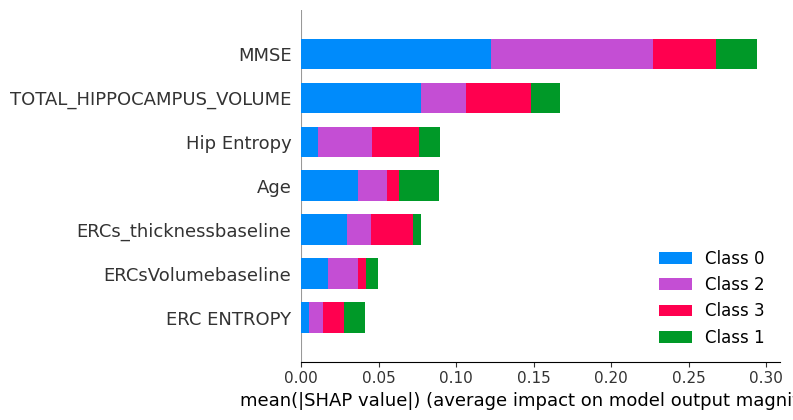

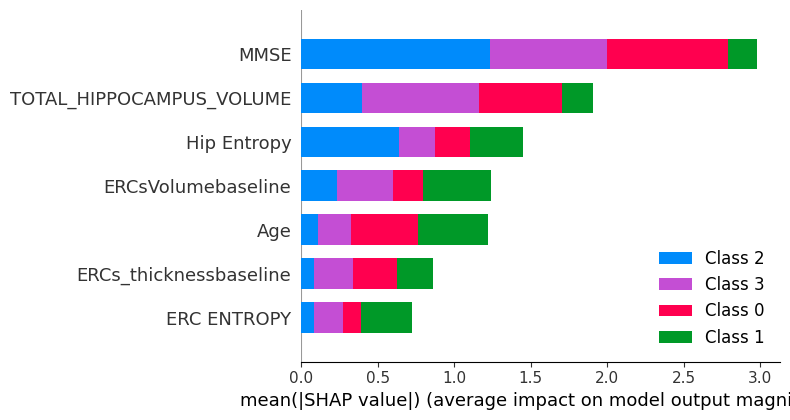

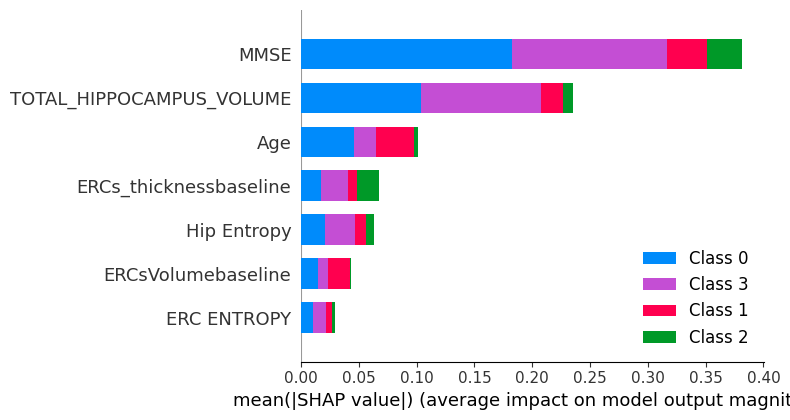

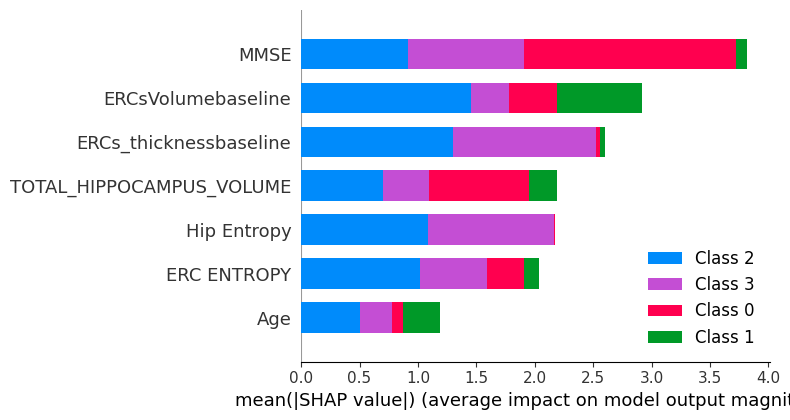

In [ ]:
# Beeswarm plots
shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")

## Local interpretability

In [ ]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(224, 7, 4)
[0.25457416 0.25107176 0.24370606 0.25064803]


In [ ]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

SHAP Beeswarm Plot for Class 0


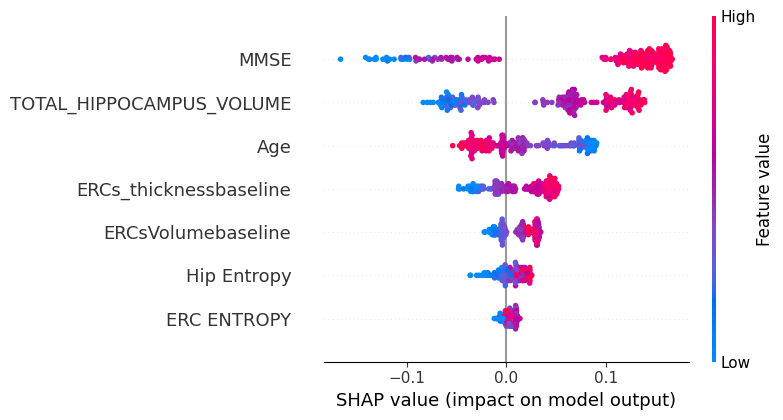

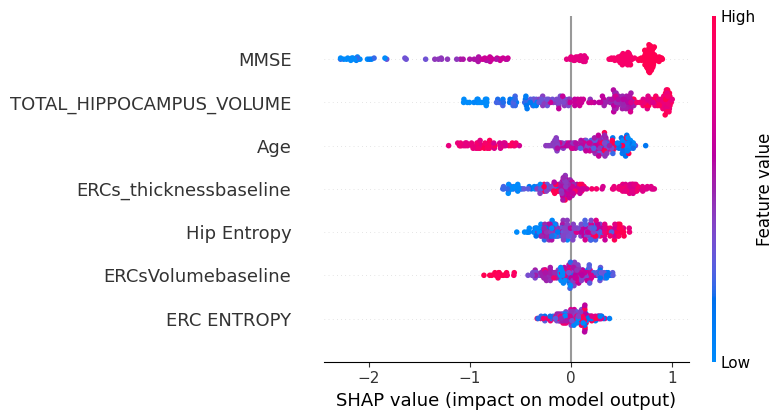

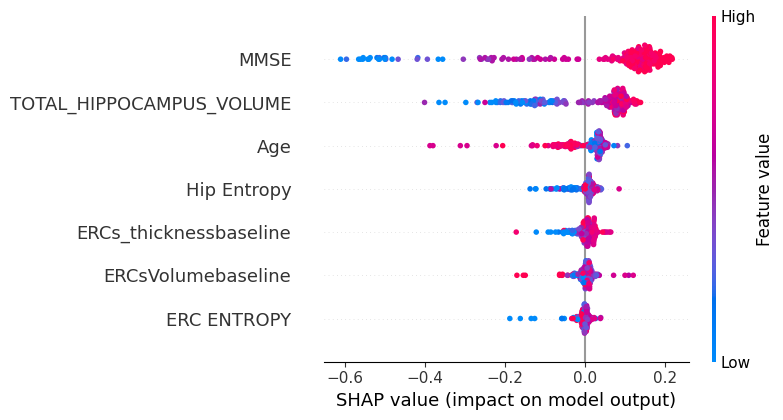

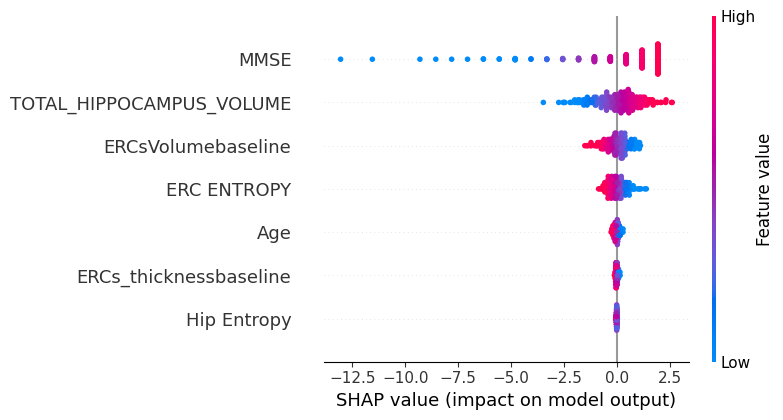

SHAP Beeswarm Plot for Class 1


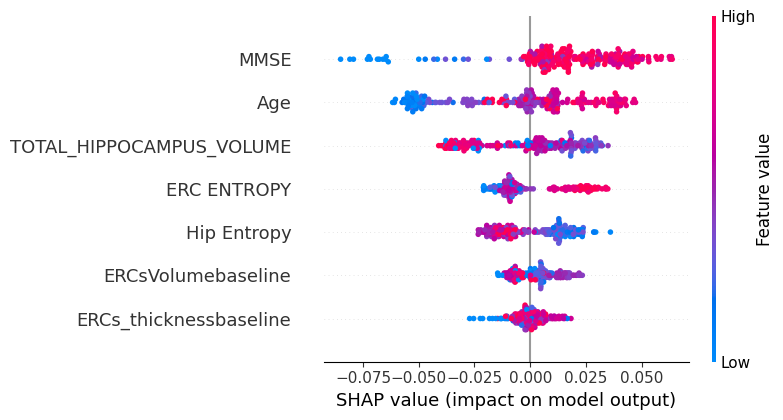

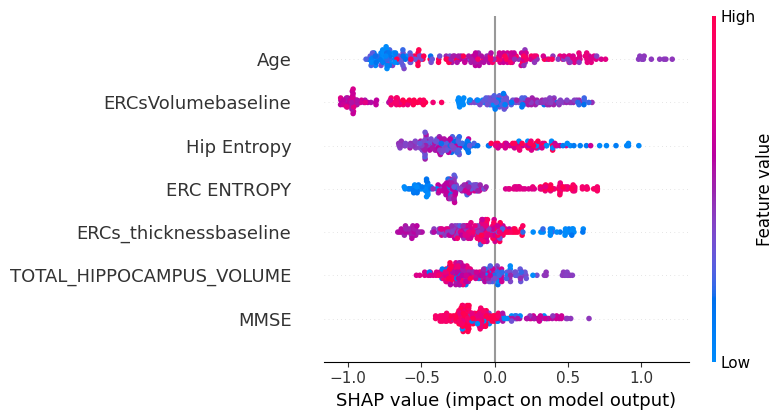

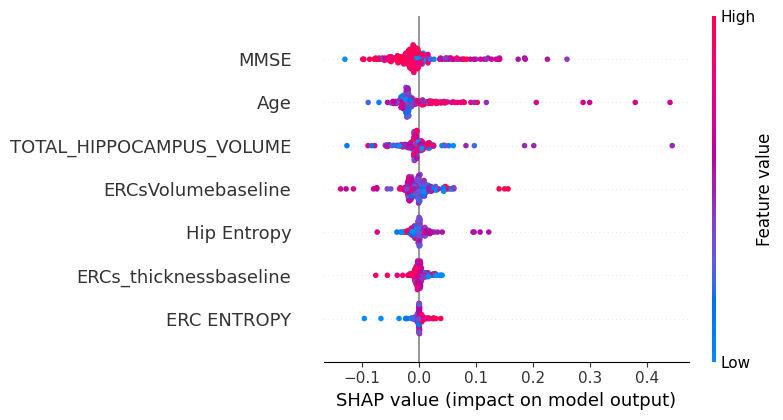

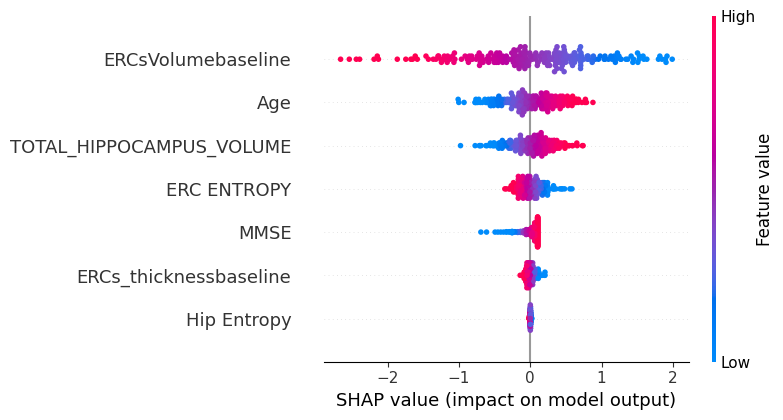

SHAP Beeswarm Plot for Class 2


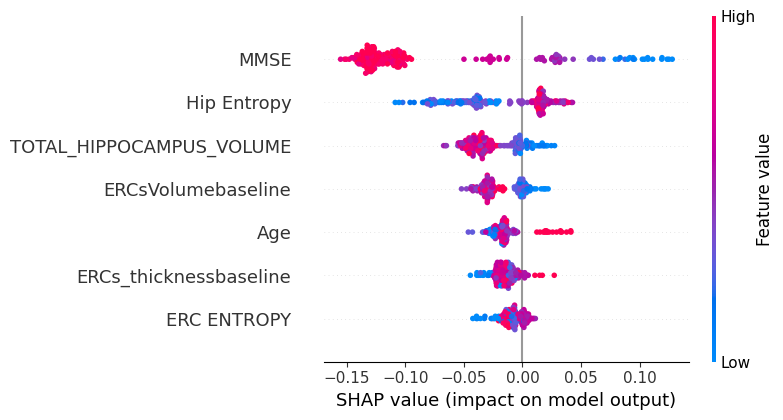

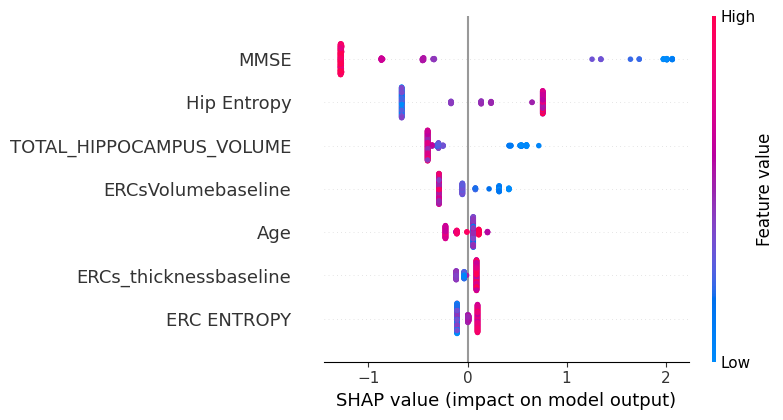

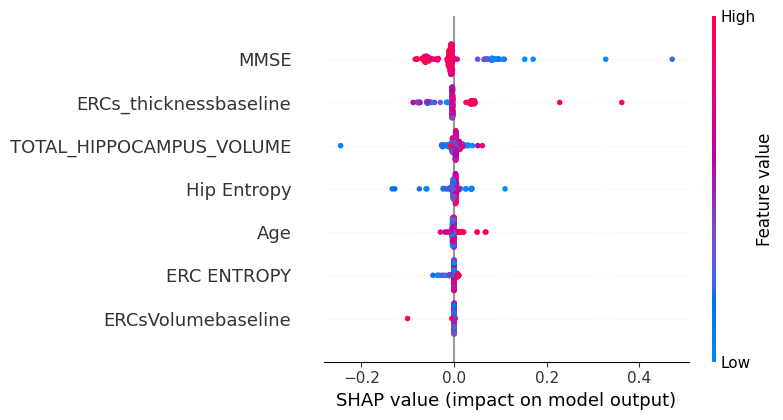

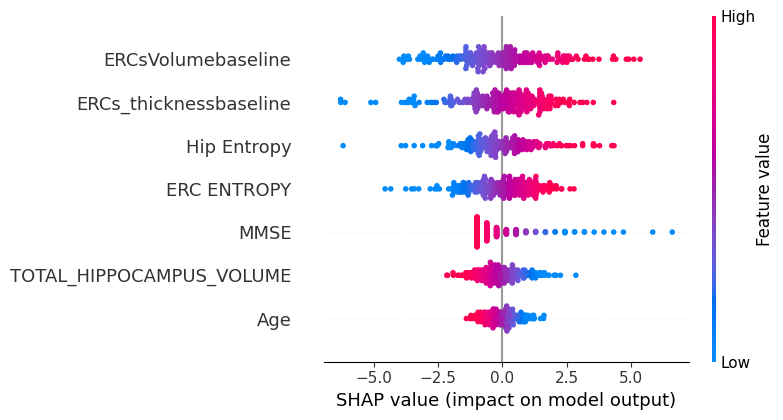

SHAP Beeswarm Plot for Class 3


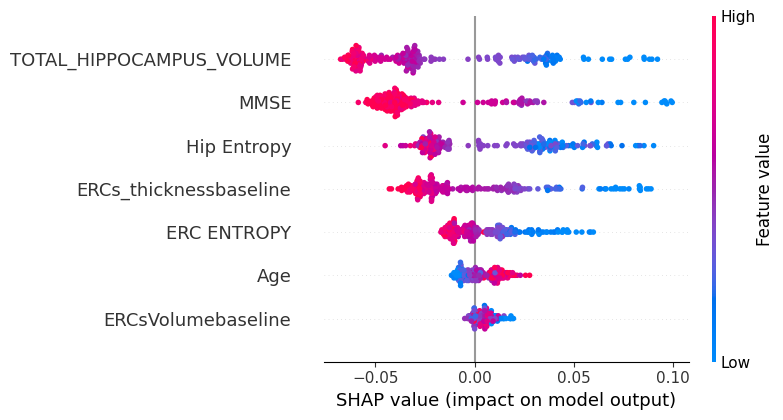

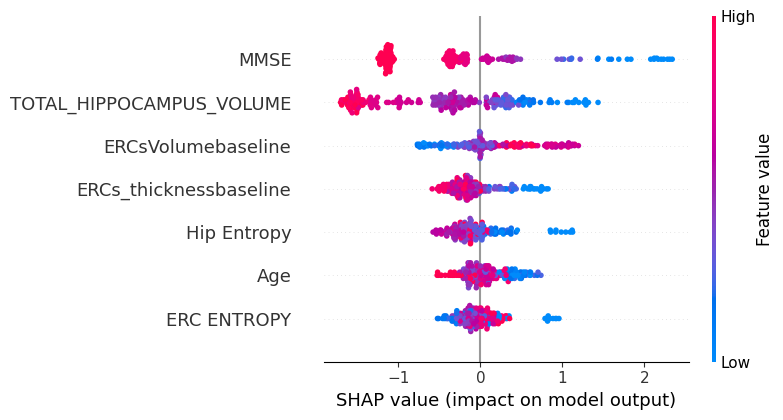

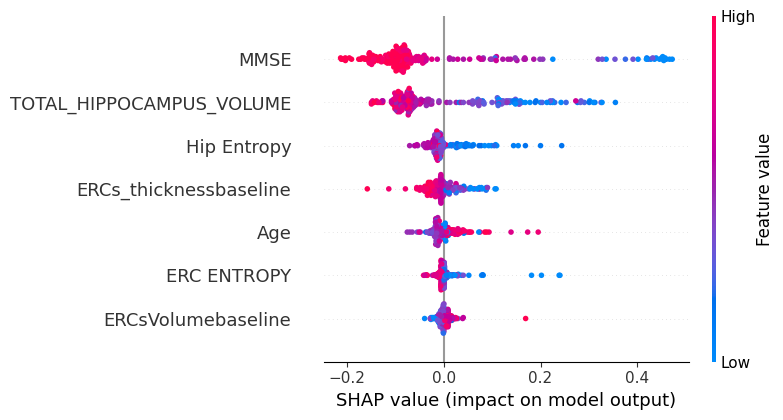

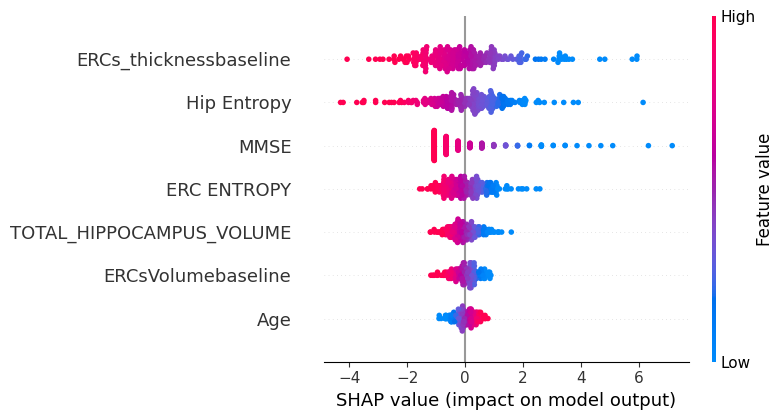

In [ ]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # XGBoost
    shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # NGBoost
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)
    
    # Logistic
    shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


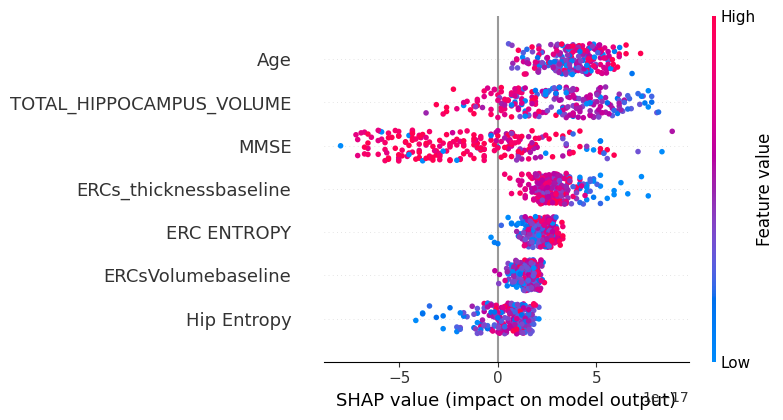

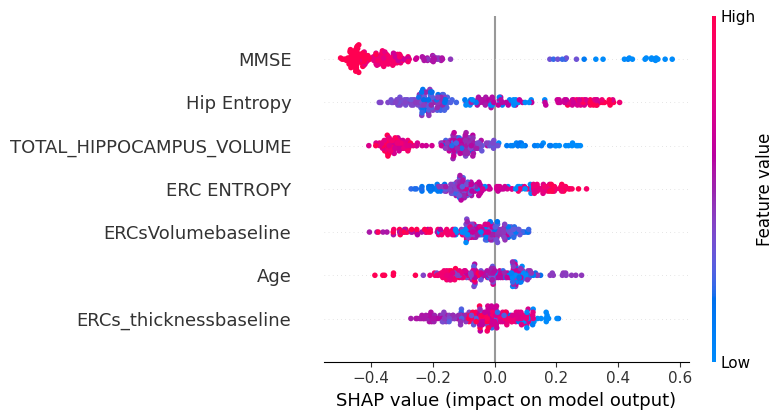

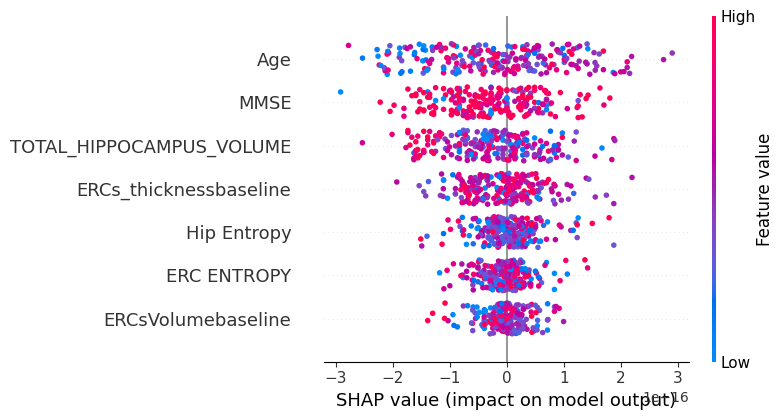

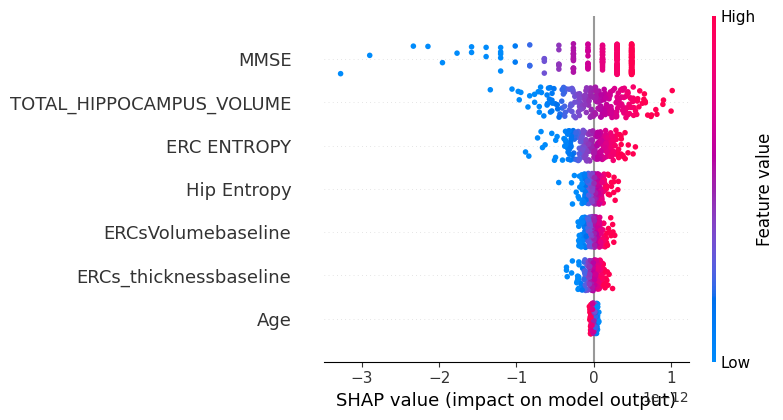

In [ ]:
shap_values_rf_mean = shap_values_rf.mean(axis=2)  # Average over classes
shap_values_xgb_mean = shap_values_xgb.mean(axis=2)
shap_values_ngb_mean = shap_values_ngb.values.mean(axis=2)
shap_values_logit_mean = shap_values_logit.mean(axis=2)
# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


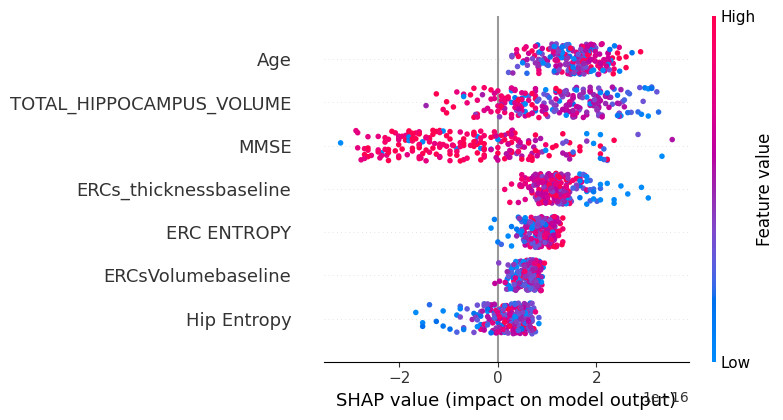

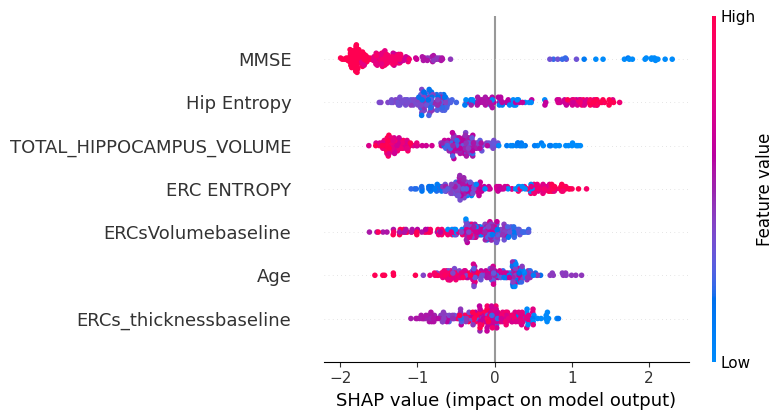

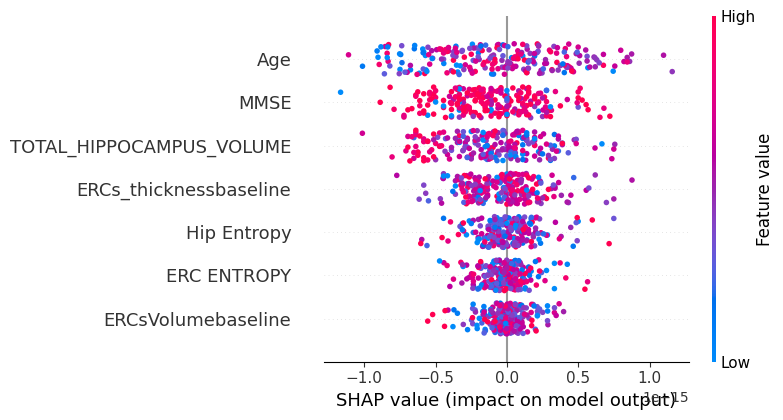

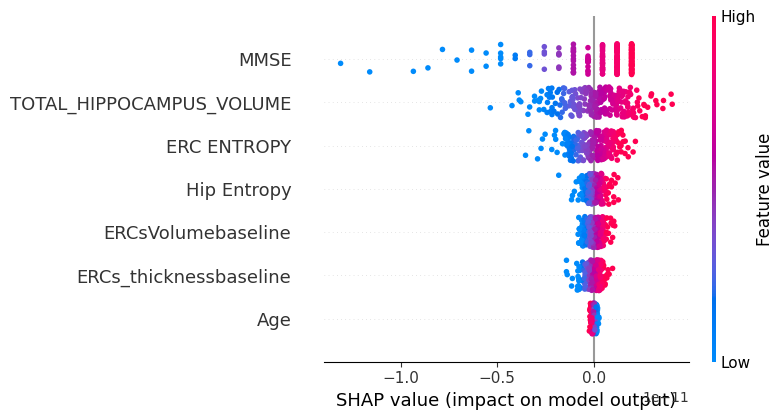

In [ ]:
shap_values_rf_sum = shap_values_rf.sum(axis=2)  # Sum over classes
shap_values_xgb_sum = shap_values_xgb.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)
shap_values_logit_sum = shap_values_logit.sum(axis=2)

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)